In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

import json

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context  # No idea what this does but it works

In [3]:
BATCH_SIZE = 32
EPOCHS = 500
LABELS = ["female", "male"]
IMG_SIZE = (224,224)

In [4]:
# Load the datasets
# In this POC, perturbed data refers to facial data processed with makeup
preprocessing_fp = "preprocessing/combined_filtered"

In [5]:
train_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "train"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 29026 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "val"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 8275 files belonging to 2 classes.


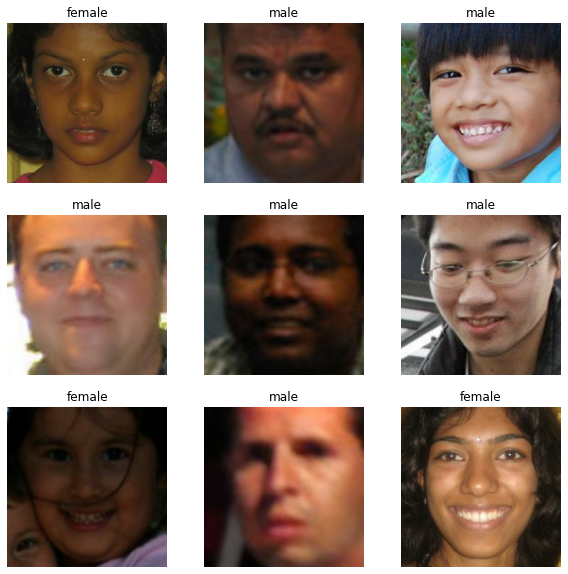

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

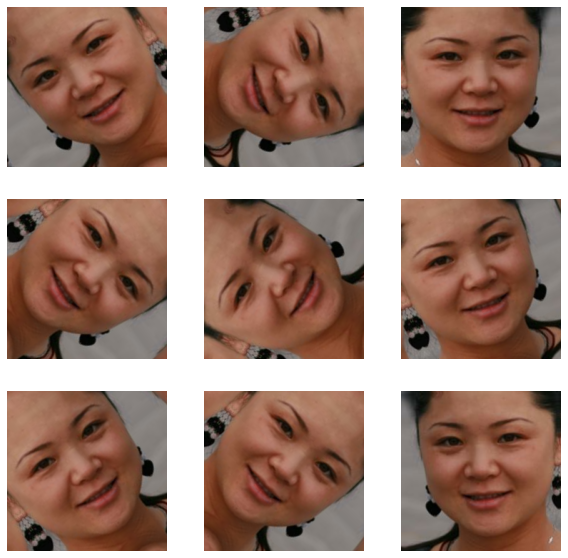

In [14]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [15]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [7]:
# Create the base model from the pre-trained model Resnet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [18]:
# Freeze all layers
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


# Beginning of Model Training
## Unperturbed model

In [20]:
# Model creation
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

In [21]:
x = global_average_layer(x)

In [22]:
x = tf.keras.layers.Dropout(0.2)(x)

In [23]:
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)

In [24]:
outputs = keras.layers.Dense(1,activation='sigmoid')(x)

In [25]:
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

loss0, accuracy0 = model.evaluate(validation_dataset)

259/259 [==============================] - 19s 67ms/step - loss: 0.7071 - accuracy: 0.5366


In [26]:
checkpoint = ModelCheckpoint(
    "model_tl_resnet_best_weights.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

# Save a checkpoint of the model for later use
history = model.fit(train_dataset,
                         epochs=EPOCHS,
                         validation_data=validation_dataset,
                        callbacks=[checkpoint])

Epoch 1/500
908/908 [==============================] - 52s 55ms/step - loss: 0.4877 - accuracy: 0.7572 - val_loss: 0.4116 - val_accuracy: 0.8025
Epoch 2/500
908/908 [==============================] - 49s 54ms/step - loss: 0.4349 - accuracy: 0.7907 - val_loss: 0.3815 - val_accuracy: 0.8215
Epoch 3/500
908/908 [==============================] - 50s 55ms/step - loss: 0.4223 - accuracy: 0.7990 - val_loss: 0.3734 - val_accuracy: 0.8274
Epoch 4/500
908/908 [==============================] - 50s 55ms/step - loss: 0.4087 - accuracy: 0.8051 - val_loss: 0.3737 - val_accuracy: 0.8240
Epoch 5/500
908/908 [==============================] - 50s 55ms/step - loss: 0.4017 - accuracy: 0.8127 - val_loss: 0.3515 - val_accuracy: 0.8422
Epoch 6/500
908/908 [==============================] - 50s 55ms/step - loss: 0.3947 - accuracy: 0.8167 - val_loss: 0.3511 - val_accuracy: 0.8392
Epoch 7/500
908/908 [==============================] - 50s 55ms/step - loss: 0.3872 - accuracy: 0.8198 - val_loss: 0.3474 - val_ac

In [27]:
# Store model history as a JSON file
with open(os.path.join("history", "model_tl_resnet_history.json"), "w") as f:
    json.dump(history.history, f) # Construct the baseline (unperturbed) model

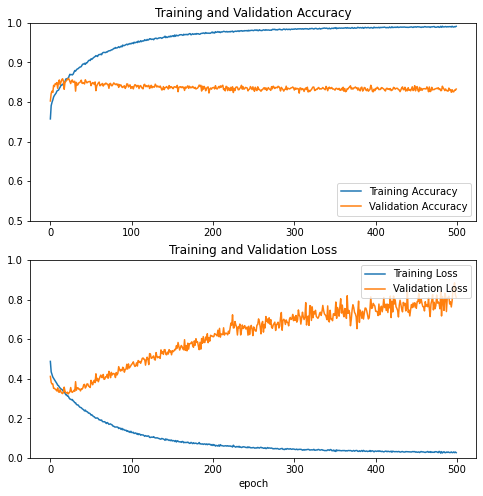

In [29]:
with open('history/model_tl_resnet_history.json') as f:
    st = json.load(f)

acc = []
val_acc = []
loss = []
val_loss = []

acc += st['accuracy']
val_acc += st['val_accuracy']

loss += st['loss']
val_loss += st['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [8]:
model = tf.keras.models.load_model('model_tl_resnet_best_weights.h5')

# Model Analysis

In [9]:
test_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "test_ori"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 4004 files belonging to 2 classes.


In [10]:
# Unravels batches
def unravel_batches(model):
    true_labels = []
    predicted = []
    for image_batch, label_batch in test_dataset.as_numpy_iterator():
        predictions = model.predict_on_batch(image_batch).flatten()
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1)
        true_labels.extend(label_batch)
        predicted.extend(predictions.numpy())
    return true_labels, predicted

In [12]:
true_labels, predicted = unravel_batches(model)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/resnet50/conv1_conv/Conv2D (defined at <ipython-input-10-27ccaa468812>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_6558]

Function call stack:
predict_function


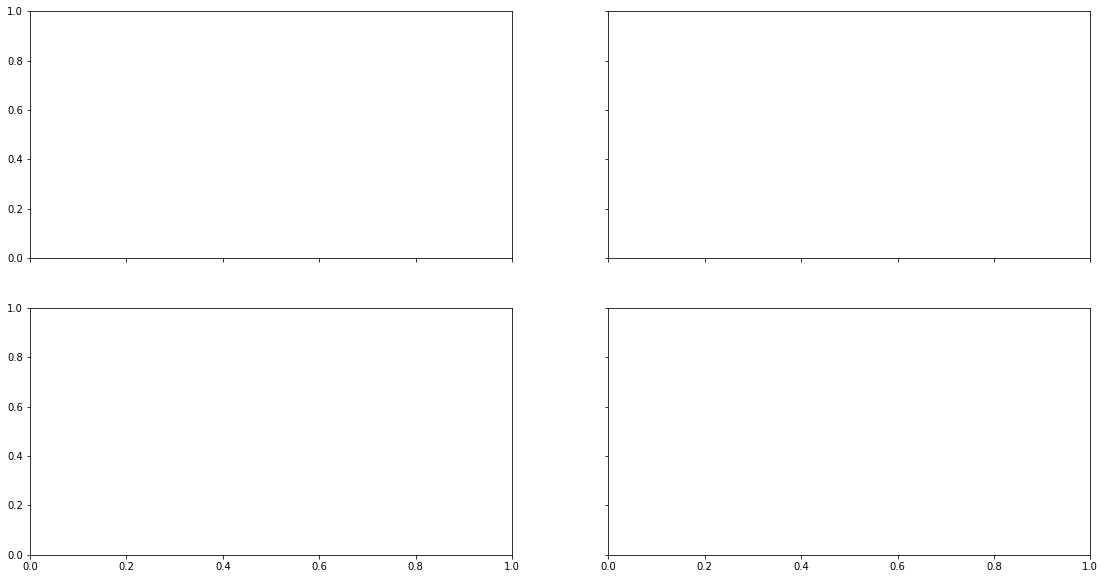

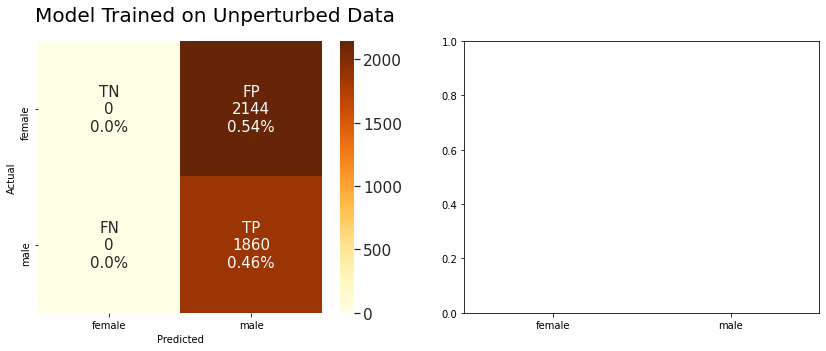

In [35]:
epochs_range = range(EPOCHS)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(19, 10))
#fig.suptitle("Unperturbed vs Perturbed")
#fig.subplots_adjust(top=0.85)

cf_matrix = confusion_matrix(true_labels, predicted)

f, ax = plt.subplots(1, 2, sharex=True, figsize=(14, 5))

# Tweak graphs and add text
ext = [
    [72.0 * 2.5, 97.04347826086959 * 2.25],
    [188.4521739130435 * 2.25, 97.04347826086956 * 2.25],
    [304.904347826087 * 2.4, 97.04347826086956 * 2.4],
    [421.35652173913047 * 2.4, 97.04347826086962 * 2.4],
]

inv = fig.transFigure.inverted()
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2.0
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2.0
right_center = inv.transform((width_right, 1))

# Unperturbed data
group_names = ["TN", "FP", "FN", "TP"]
group_counts = map(round, cf_matrix.flatten())
group_percentages = (
    f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
)
df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
labels = np.asarray(
    ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
).reshape(2, 2)

# Confusion matrix titles
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2
right_center = inv.transform((width_right, 1))
plt.figtext(
    left_center[0],
    0.95,
    "Model Trained on Unperturbed Data",
    va="center",
    ha="center",
    size=20,
)

sns.set(font_scale=1.4)  # for label size
sns.heatmap(
    df_cm,
    annot=labels,
    annot_kws={"size": 15},
    cmap="YlOrBr",
    fmt="",
    ax=ax[0],
    xticklabels=LABELS,
    yticklabels=LABELS,
)
sns.set_style("darkgrid")
plt.show()

In [34]:
print(classification_report(
        true_labels, predicted, target_names=LABELS, zero_division=1
    )
)

              precision    recall  f1-score   support

      female       1.00      0.00      0.00      1034
        male       0.52      1.00      0.69      1142

    accuracy                           0.52      2176
   macro avg       0.76      0.50      0.34      2176
weighted avg       0.75      0.52      0.36      2176

